In [4]:
import pandas as pd
import numpy as np
import os


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

## Après cleaning.ipynb


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df = pd.read_feather("data/houses_madrid_cleaned.feather")
df.head()

,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21742,64,60,2,1,<NA>,<NA>,3,0,471,85000,1328,0,False,1960,<NA>,<NA>,1,0,0,1,0,0,0,0,0,0,0,d,0,<NA>,<NA>,0,1,0,0,piso,135
21741,70,<NA>,3,1,<NA>,<NA>,4,0,666,129900,1856,1,False,<NA>,<NA>,<NA>,0,1,1,1,0,0,1,0,0,0,0,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,132
21740,94,54,2,2,<NA>,<NA>,1,0,722,144247,1535,0,False,<NA>,0,1,0,1,1,1,0,0,0,0,1,0,0,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,134
21739,64,<NA>,2,1,<NA>,<NA>,bajo,1,583,109900,1717,0,False,1955,<NA>,<NA>,0,0,1,1,0,0,0,0,1,1,0,None,0,<NA>,<NA>,0,0,1,0,piso,134
21738,108,90,2,2,<NA>,<NA>,4,0,1094,260000,2407,0,False,2003,<NA>,<NA>,1,1,1,1,0,1,0,0,1,0,1,None,1,1,0,1,1,1,1,piso,133


<div style="background-color: #439cc8; color: white; font-size: 16px; font-style: italic; padding: 10px 15px; margin-bottom: 15px; border-radius: 8px;">
  <h3>Train/Test Split</h3>
  <p>Le split est réalisé après le nettoyage structurel pour éviter toute fuite d'information. Les transformations apprises seront toujours basées sur le jeu d'entraînement.</p>
</div>

In [6]:
# Split et sauvegarde des jeux d'entraînement et de test
target_col = 'buy_price'
y = df[target_col]
X = df.drop(columns=[target_col])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
 )

# Sauvegarde au format feather
os.makedirs('data_model', exist_ok=True)
X_train.reset_index(drop=True).to_feather('data_model/X_train.feather')
X_test.reset_index(drop=True).to_feather('data_model/X_test.feather')
y_train.to_frame(name=target_col).reset_index(drop=True).to_feather('data_model/y_train.feather')
y_test.to_frame(name=target_col).reset_index(drop=True).to_feather('data_model/y_test.feather')

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}\ny_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (17247, 36), X_test: (4312, 36)
y_train: (17247,), y_test: (4312,)


# Analyse du Train set
## Dataset
- **Taille initiale** : 17393 lignes et 36 colonnes (avant nettoyage)
- **Unité statistique** : 1 ligne = 1 bien immobilier (une annonce)

## Description des variables (résumé)
Le dataset contient :
- des **variables numériques** (surfaces, pièces, prix, étage…)
- des **variables binaires** (équipements : ascenseur, parking, jardin, piscine…)
- des **variables catégorielles** (type de bien `product`, quartier `neighborhood`, etc.)

## Target
- Target principale : **buy_price**
- Target utilisée pour la régression : **log_buy_price = log1p(buy_price)**
  - Motivation : la distribution de `buy_price` est très asymétrique (présence d’outliers),
    la transformation log réduit l’écart entre les valeurs extrêmes et stabilise la variance.

## Gestion des valeurs manquantes
- **Suppression de colonnes** : toutes les colonnes avec **plus de 40% de valeurs manquantes** sont supprimées.
  - Objectif : éviter d’imputer des variables trop incomplètes et donc peu fiables.

- **Variables binaires (0/1)** : imputation par la **valeur la plus fréquente (mode)**.
  - Hypothèse : lorsqu’une information est manquante, elle correspond le plus souvent au cas majoritaire.
  - Intérêt : conserver un maximum de lignes sans introduire une valeur artificielle.

- **Variable `floor` (étage)** : nettoyage + imputation
  - Conversion de `"bajo"` (rez-de-chaussée) en **0**
  - Conversion en numérique (les valeurs non convertibles deviennent NaN)
  - Imputation des NaN par la **médiane**
  - Motivation : méthode robuste, simple et adaptée à une variable discrète avec quelques valeurs extrêmes.

- **Variables numériques avec faible taux de NA** (ex : `sq_mt_built`, `n_bathrooms`) :
  - Conversion en numérique puis imputation des NA par la **médiane**
  - Motivation : méthode robuste aux outliers, simple et efficace.

## Traitement des incohérences / valeurs extrêmes
- **rent_price** : valeurs négatives considérées comme incohérentes
  - Règle : `rent_price < 0` → NaN, puis imputation par la **médiane**
  - Remarque : si `rent_price` est utilisée en feature, il est préférable d’ajouter un indicateur de manquants pour distinguer les valeurs imputées.

- Les distributions de certaines variables (surfaces, prix) présentent des extrêmes.
  - La transformation log de la target est prioritaire pour stabiliser la régression.
  - Les outliers très manifestes peuvent être traités ensuite (filtrage ou cap) selon les besoins du modèle.

## Variables retenues (features)
Les variables retenues pour la modélisation sont principalement :
- **variables structurelles** : `sq_mt_built`, `n_rooms`, `n_bathrooms`
- **variable de zone** : `neighborhood` (identifiant de quartier)
- **variables d’équipements** : `has_lift`, `has_parking`, `has_pool`, `has_garden`, `has_storage_room`
- **variables complémentaires** : `is_floor_under`

## Hypothèses métier
- **Surface** : plus la surface construite augmente, plus le prix augmente.
- **Pièces / SDB** : plus il y a de chambres et de salles de bain, plus le prix augmente (effet de palier possible).
- **Zone** : le quartier (`neighborhood`) capte une grande partie de la variance des prix (effet non forcément linéaire).
- **Équipements** : ascenseur, parking, piscine, jardin, cave augmentent le prix à caractéristiques égales.


In [7]:
X_train.head()

,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10064,60,<NA>,0,1,<NA>,<NA>,6,0,1711,8656,0,False,<NA>,0,1,1,1,1,1,0,1,0,0,0,0,0,f,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,estudio,36
20844,61,55,3,1,<NA>,<NA>,4,0,646,2049,1,False,1965,0,1,0,0,0,1,0,0,0,0,0,0,0,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,124
10316,148,<NA>,3,3,<NA>,<NA>,3,0,2514,6419,0,False,1968,0,1,1,1,1,1,0,0,0,0,0,0,0,None,0,<NA>,<NA>,0,1,0,0,piso,35
3641,72,68,2,2,<NA>,<NA>,4,0,1148,3889,0,False,<NA>,0,1,1,1,1,0,0,0,0,0,0,0,0,None,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,piso,22
5796,70,62,3,1,<NA>,<NA>,2,0,705,1999,0,None,<NA>,<NA>,<NA>,1,0,0,1,0,0,0,0,0,0,0,g,0,<NA>,<NA>,0,0,1,0,piso,13


## 2) Data overview
- Dimensions
- Types / valeurs manquantes
- Statistiques descriptives


In [8]:
print("Shape:", X_train.shape)
X_train.info()
display(X_train.describe(include="all").T)


Shape: (17247, 36)
<class 'pandas.core.frame.DataFrame'>
Index: 17247 entries, 10064 to 5846
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   sq_mt_built                   17143 non-null  UInt16
 1   sq_mt_useful                  6520 non-null   UInt16
 2   n_rooms                       17247 non-null  int64 
 3   n_bathrooms                   17232 non-null  UInt8 
 4   n_floors                      1140 non-null   UInt8 
 5   sq_mt_allotment               1125 non-null   UInt64
 6   floor                         15181 non-null  object
 7   is_floor_under                16321 non-null  UInt8 
 8   rent_price                    17247 non-null  int64 
 9   buy_price_by_area             17247 non-null  int64 
 10  is_renewal_needed             17247 non-null  UInt8 
 11  is_new_development            16470 non-null  object
 12  built_year                    7951 non-null   UInt16
 13 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sq_mt_built,17143.0,<NA>,<NA>,<NA>,146.945459,133.908715,13.0,70.0,100.0,163.0,998.0
sq_mt_useful,6520.0,<NA>,<NA>,<NA>,103.557669,88.181158,1.0,59.0,79.0,113.0,998.0
n_rooms,17247.0,NaN,NaN,NaN,3.008523,1.515847,0.0,2.0,3.0,4.0,24.0
n_bathrooms,17232.0,<NA>,<NA>,<NA>,2.093141,1.407251,1.0,1.0,2.0,2.0,15.0
n_floors,1140.0,<NA>,<NA>,<NA>,3.135965,0.912274,1.0,2.0,3.0,4.0,7.0
sq_mt_allotment,1125.0,<NA>,<NA>,<NA>,234.145778,245.094771,1.0,2.0,228.0,350.0,997.0
floor,15181,19,1,3536,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_floor_under,16321.0,<NA>,<NA>,<NA>,0.121439,0.326646,0.0,0.0,0.0,0.0,1.0
rent_price,17247.0,NaN,NaN,NaN,-58879.804198,903516.73046,-34590276.0,725.0,1119.0,1689.0,2517.0
buy_price_by_area,17247.0,NaN,NaN,NaN,4015.819389,1910.615992,447.0,2543.0,3717.0,5000.0,18889.0


## 3) Missing
On mesure le % de valeurs manquantes et le nombre de doublons stricts (lignes identiques).


In [9]:
missing_pct = (X_train.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct.to_frame("%_missing").head(30))

dup_count = X_train.duplicated().sum()
print("Doublons (lignes identiques):", dup_count)


,%_missing
sq_mt_allotment,93.477126
n_floors,93.390155
energy_certificate,67.246478
is_parking_included_in_price,64.556155
parking_price,64.556155
sq_mt_useful,62.196324
built_year,53.899229
is_orientation_north,47.892387
is_orientation_south,47.892387
is_orientation_east,47.892387


Doublons (lignes identiques): 55


## 4) Cleaning (en un bloc)

### Choix appliqués
- **Drop colonnes > 40% NA**
- **NA binaires** : Valeur la plus fréquente 
- **floor** : "bajo"→0, conversion numérique, médiane + `floor_missing`
- **rent_price** : négatifs → NaN, puis médiane + `rent_price_missing`
- **Target** : `log_buy_price = log1p(buy_price)`


In [10]:


# 4.2 Drop colonnes > 60% NA
threshold = 0.40
cols_to_drop = X_train.columns[X_train.isna().mean() > threshold]
X_train = X_train.drop(columns=cols_to_drop)
print("Colonnes supprimées (>40% NA):", list(cols_to_drop))

# 4.3 Binaires : 0 + flags missing
bin_cols = ["has_individual_heating","has_central_heating","is_exterior","has_lift","is_floor_under","is_new_development"]

for c in bin_cols:
    X_train[c] = X_train[c].fillna(X_train[c].mode()[0])


# 4.4 floor : nettoyage + médiane + flag
if "floor" in X_train.columns:
    X_train["floor"] = X_train["floor"].replace({"bajo": 0})
    X_train["floor"] = pd.to_numeric(X_train["floor"], errors="coerce")
    X_train["floor"] = X_train["floor"].fillna(X_train["floor"].median())

# 4.5 Numériques faible NA : médiane
num_cols = ["sq_mt_built", "n_bathrooms"]
for c in num_cols:
    if c in X_train.columns:
        X_train[c] = pd.to_numeric(X_train[c], errors="coerce")
        X_train[c] = X_train[c].fillna(X_train[c].median())

# 4.6 rent_price : négatifs -> NaN, puis médiane + flag
if "rent_price" in X_train.columns:
    X_train["rent_price"] = pd.to_numeric(X_train["rent_price"], errors="coerce")
    X_train.loc[X_train["rent_price"] < 0, "rent_price"] = np.nan
    X_train["rent_price"] = X_train["rent_price"].fillna(X_train["rent_price"].median())

# 4.7 log target
X_train["log_buy_price"] = np.log1p(y_train)

print("Shape après cleaning:", X_train.shape)

Colonnes supprimées (>40% NA):

 ['sq_mt_useful', 'n_floors', 'sq_mt_allotment', 'built_year', 'energy_certificate', 'is_parking_included_in_price', 'parking_price', 'is_orientation_north', 'is_orientation_west', 'is_orientation_south', 'is_orientation_east']
Shape après cleaning: (17247, 26)


C:\Users\coule\AppData\Local\Temp\ipykernel_13164\1001377290.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train[c] = X_train[c].fillna(X_train[c].mode()[0])


## 5) Contrôle rapide après cleaning
On recheck : shape, missing, stats rapides.


In [11]:
print("Shape:", X_train.shape)
display((X_train.isna().mean() * 100).sort_values(ascending=False).head(20).to_frame("%_missing"))
display(X_train.describe(include="all").T.head(25))


Shape: (17247, 26)


,%_missing
sq_mt_built,0.0
n_rooms,0.0
n_bathrooms,0.0
floor,0.0
is_floor_under,0.0
rent_price,0.0
buy_price_by_area,0.0
is_renewal_needed,0.0
is_new_development,0.0
has_central_heating,0.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
sq_mt_built,17247.0,<NA>,<NA>,<NA>,146.662376,133.553809,13.0,70.0,100.0,162.0,998.0
n_rooms,17247.0,NaN,NaN,NaN,3.008523,1.515847,0.0,2.0,3.0,4.0,24.0
n_bathrooms,17247.0,<NA>,<NA>,<NA>,2.09306,1.406642,1.0,1.0,2.0,2.0,15.0
floor,17247.0,NaN,NaN,NaN,2.579231,1.904107,0.0,1.0,2.0,4.0,9.0
is_floor_under,17247.0,<NA>,<NA>,<NA>,0.114919,0.318933,0.0,0.0,0.0,0.0,1.0
rent_price,17247.0,NaN,NaN,NaN,1329.696643,551.850718,18.0,901.0,1218.0,1689.0,2517.0
buy_price_by_area,17247.0,NaN,NaN,NaN,4015.819389,1910.615992,447.0,2543.0,3717.0,5000.0,18889.0
is_renewal_needed,17247.0,<NA>,<NA>,<NA>,0.185134,0.388417,0.0,0.0,0.0,0.0,1.0
is_new_development,17247,2,False,16070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_central_heating,17247.0,<NA>,<NA>,<NA>,0.187569,0.390379,0.0,0.0,0.0,0.0,1.0


## 6) EDA courte (10 graphes max)

Objectif :
- vérifier la distribution de la target (brut + log)
- visualiser quelques variables clés
- vérifier 2-3 relations avec le prix


In [12]:
# Colonnes numériques de X_train
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# Concaténer X_train et y_train pour la corrélation
df_corr = X_train[num_cols].copy()
df_corr["target"] = y_train

# Corrélation avec la target
corr_target = (
    df_corr.corr(numeric_only=True)["target"]
    .drop("target")
)

# Top 6 variables les plus corrélées (valeur absolue)
top_cols = (
    corr_target.abs()
    .sort_values(ascending=False)
    .head(6)
    .index
    .tolist()
)

print("Top 6 variables (corr abs) avec y_train :", top_cols)


Top 6 variables (corr abs) avec y_train : ['log_buy_price', 'n_rooms', 'buy_price_by_area', 'rent_price', 'floor']


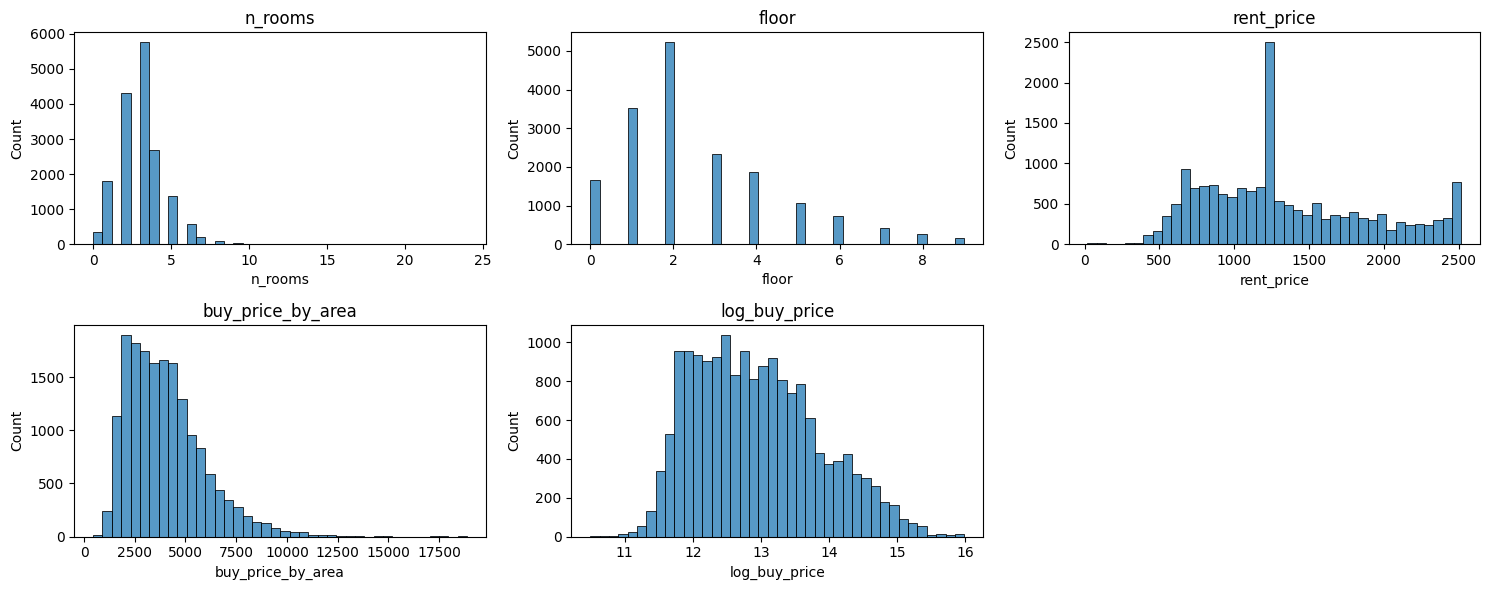

In [13]:
import math

n_cols = 3                      # nombre de graphes par ligne
n_plots = len(num_cols)
n_rows = math.ceil(n_plots / n_cols)

plt.figure(figsize=(n_cols * 5, n_rows * 3))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train[col].dropna(), bins=40)
    plt.title(col)

plt.tight_layout()
plt.show()


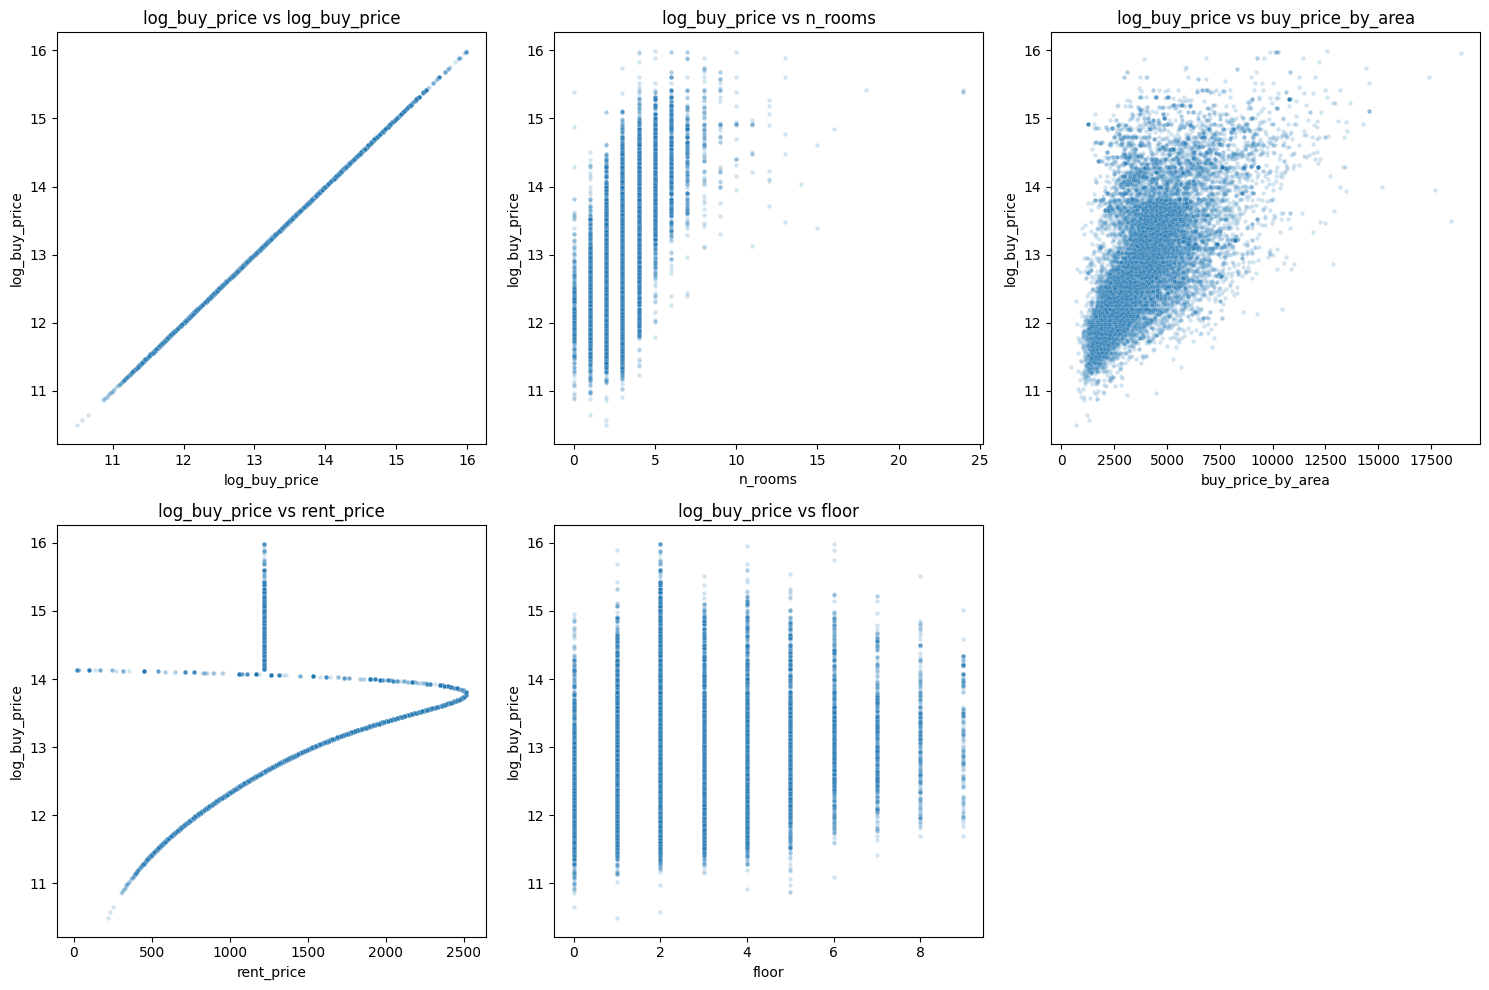

In [14]:
# Assure log_buy_price
if "log_buy_price" not in X_train.columns and "buy_price" in X_train.columns:
    X_train["log_buy_price"] = np.log1p(X_train["buy_price"])

# Colonnes numériques
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# 2) Scatter top 6 vs target
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_cols[:6], 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(x=X_train[col], y=X_train["log_buy_price"], s=10, alpha=0.2)
    plt.title(f"log_buy_price vs {col}")
plt.tight_layout()
plt.show()


## 7) Sélection des features + export

On conserve un set de variables cohérent pour la régression :
- target : `log_buy_price`
- features : surfaces, pièces, prix/m², quartier, équipements
- export d’un CSV “prêt pour modèle”


In [15]:
features = [
    "log_buy_price",
    "product",
    "sq_mt_built", "n_rooms", "n_bathrooms",
    "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room",
    "is_floor_under",
    "floor"
]

# garder uniquement celles qui existent
features = [c for c in features if c in X_train.columns]

X_train_model = X_train[features].copy()



## 8) Heatmap de corrélation

Objectif : visualiser les corrélations entre les variables numériques retenues (et la target `log_buy_price`).

- Une corrélation proche de **+1** : variables évoluent ensemble
- Proche de **-1** : relation inverse
- Proche de **0** : peu de relation linéaire

⚠️ Attention : corrélation ≠ causalité.  
On s’en sert surtout pour repérer :
- variables très liées (multicolinéarité possible)
- variables fortement liées à la target


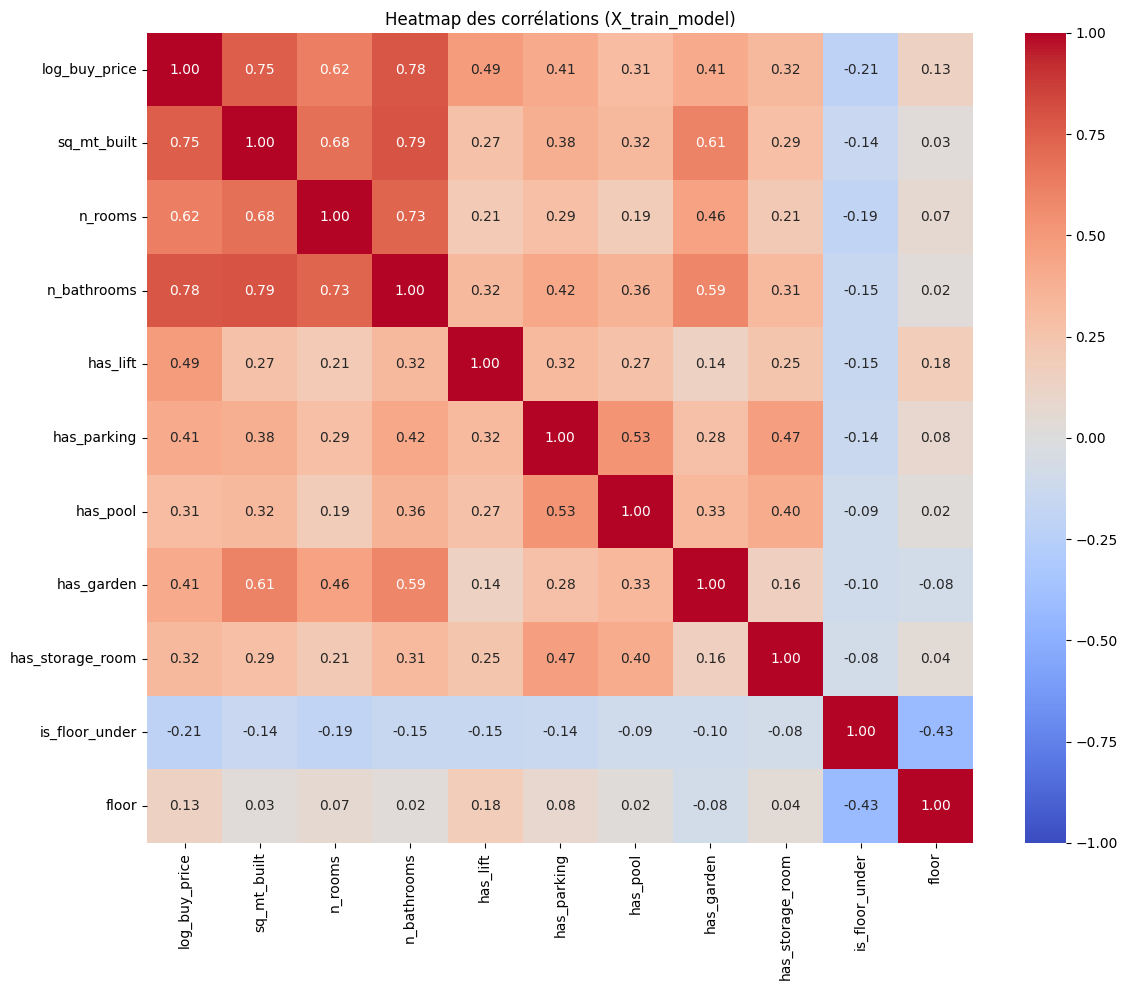

In [16]:
corr = X_train_model.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Heatmap des corrélations (X_train_model)")
plt.tight_layout()
plt.show()

In [17]:
X_train_model = X_train_model.drop(columns=["floor"])

La target buy_price est très asymétrique (outliers importants). La transformation log_buy_price rend la distribution plus proche d’une forme exploitable et stabilise la variance.

sq_mt_built et n_bathrooms montrent la relation la plus forte avec le prix (corr ≈ 0.75–0.78) et une tendance positive claire sur les scatterplots.

n_rooms est également corrélé mais redondant avec la surface et les salles de bain (multicolinéarité), ce qui peut rendre les coefficients instables en régression linéaire.

Les équipements (has_parking, has_garden, has_storage_room, has_pool, has_lift) apportent un signal complémentaire modéré.


neighborhood est conservé mais la corrélation linéaire faible est attendue car il s’agit d’un identifiant : l’effet quartier est plutôt non-linéaire/catégoriel.

floor a un signal faible (corr ≈ 0.14) et redondant avec is_floor_under, donc il est retiré dans une version simplifiée des features.

## 10) Export du dataset final

On exporte le dataset de features prêt à être utilisé par les modèles de régression.


In [ ]:
# 1. Création du dossier de destination
os.makedirs('data_model', exist_ok=True)

# 2. Préparation des features (X)
# On réinitialise les index car le format .feather l'exige
X_train_final = X_train.reset_index(drop=True)
X_test_final = X_test.reset_index(drop=True)

# 3. Préparation des cibles (y)
# On convertit les Series en DataFrame et on reset l'index
y_train_final = y_train.to_frame().reset_index(drop=True)
y_test_final = y_test.to_frame().reset_index(drop=True)

# Optionnel : Si vous utilisez la log-transformation pour l'entraînement
if 'buy_price' in y_train_final.columns:
    y_train_final['log_buy_price'] = np.log1p(y_train_final['buy_price'])

# 4. Export effectif au format Feather (très rapide et conserve les types)
X_train_final.to_feather('data_model/X_train.feather')
X_test_final.to_feather('data_model/X_test.feather')
y_train_final.to_feather('data_model/y_train.feather')
y_test_final.to_feather('data_model/y_test.feather')

print("✅ Export terminé des 4 jeux X/y train/test dans data_model/ !")
print(f"Train set : {X_train_final.shape}")
print(f"Test set  : {X_test_final.shape}")

✅ Export terminé avec succès !
Train set : (17247, 26)
Test set  : (4312, 36)
